In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
import pickle
import json

import tensorflow as tf
from tensorflow.keras import layers, models, activations
import tensorflow.keras as keras
import matplotlib.pyplot as plt
import numpy as np
from tqdm.notebook import tqdm
import seaborn as sns

from utils import parse_function, filter_function, augmentation_function, data_pipeline

Define constants.

In [3]:
MODEL_PATH = "C:/Users/Tim/.keras/datasets/greenspace_transfer/models/"
DATA_PATH = "C:/Users/Tim/.keras/datasets/greenspace_transfer/ohsome2label/"
BATCH_SIZE = 16

### Example images

In [4]:
with open('city_bboxes.json', 'r') as fin:
    city_bboxes = json.load(fin)
    
train_cities = list(city_bboxes.keys())[:15]
transfer_cities = list(city_bboxes.keys())[15:]

X = []
Y = []
for city in train_cities:
    img_dir = DATA_PATH+city+"/images/"
    label_dir = DATA_PATH+city+"/labels/"
    X.extend([img_dir+fname for fname in os.listdir(img_dir)])
    Y.extend([label_dir+fname for fname in os.listdir(label_dir)])
    
X_transfer_single = []
Y_transfer_single = []
for city in transfer_cities:
    img_dir = DATA_PATH+city+"/images/"
    label_dir = DATA_PATH+city+"/labels/"
    X_transfer_single.append([img_dir+fname for fname in os.listdir(img_dir)])
    Y_transfer_single.append([label_dir+fname for fname in os.listdir(label_dir)])
X_transfer = [j for sub in X_transfer_single for j in sub]
Y_transfer = [j for sub in Y_transfer_single for j in sub]

In [5]:
train_pipeline = data_pipeline(X, Y, batch_size=BATCH_SIZE, train_mode=True)
transfer_pipeline = data_pipeline(X_transfer, Y_transfer, batch_size=BATCH_SIZE)
iter_pipe_train = iter(train_pipeline)
iter_pipe_transfer = iter(transfer_pipeline)

In [26]:
batch_train = next(iter_pipe_train)
batch_transfer = next(iter_pipe_transfer)

imgs_train = batch_train[0]
imgs_transfer = batch_transfer[0]

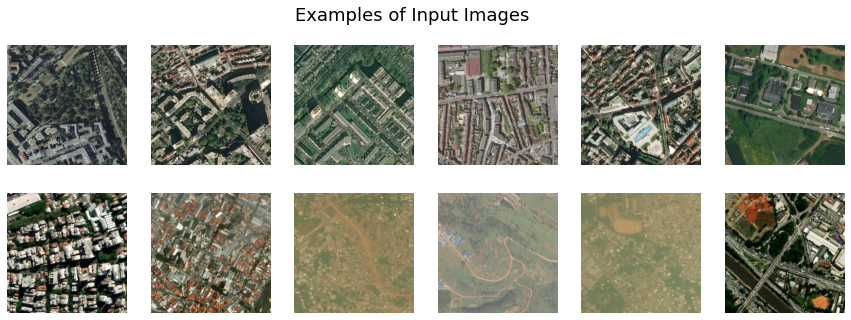

In [28]:
fig, axarr = plt.subplots(2, 6, figsize=(15, 5))
fig.suptitle("Examples of Input Images", fontsize=18)
for col in range(6):
    img = imgs_train[col]
    axarr[0, col].imshow(img)
    axarr[0, col].axis('off')
    
for col in range(6):
    img = imgs_transfer[col]
    axarr[1, col].imshow(img)
    axarr[1, col].axis('off')

plt.savefig(f'plots/example_input_images.png', bbox_inches='tight', dpi=120)
plt.show()

In [6]:
batch_train = next(iter_pipe_train)

saved_images = batch_train[0]
saved_labels = batch_train[1]

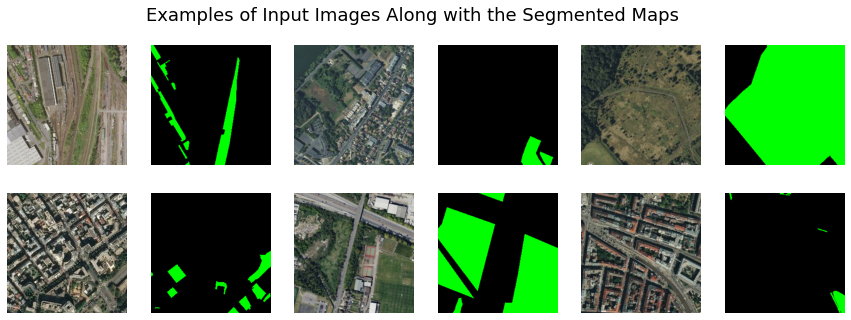

In [7]:
flattened_img_labels = [item for sublist in zip(saved_images, saved_labels) for item in sublist]
fig, axarr = plt.subplots(2, 6, figsize=(15, 5))
fig.suptitle("Examples of Input Images Along with the Segmented Maps", fontsize=18)
i = 0
for row in range(2):
    for col in range(6):
        img = flattened_img_labels[i]
        if img.shape[2] == 1:
            img = np.concatenate([img, img, img], axis=2)
            img[..., 0] = 0
            img[..., 2] = 0
        axarr[row, col].imshow(img)
        axarr[row, col].axis('off')
        i += 1

plt.savefig(f'plots/example_images.png', bbox_inches='tight', dpi=120)
plt.show()

### Plotting learning curve

In [6]:
with open(MODEL_PATH+'unet_vanilla/history.pkl', 'rb') as fin:
    history_unet = pickle.load(fin)
with open(MODEL_PATH+'unet_frozen_resnet50_noaug/history.pkl', 'rb') as fin:
    history_resunet = pickle.load(fin)
with open(MODEL_PATH+'unet_frozen_seresnext50/history.pkl', 'rb') as fin:
    history_resuneta = pickle.load(fin)
with open(MODEL_PATH+'unet_finetuned_seresnext50/history.pkl', 'rb') as fin:
    history_resunetaf = pickle.load(fin)

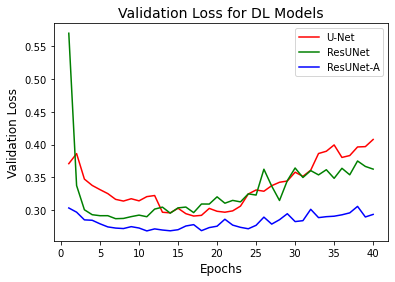

In [18]:
epochs = range(1, 41)
plt.plot(epochs, history_unet['val_loss'], 'r', label='U-Net')
plt.plot(epochs, history_resunet['val_loss'], 'g', label='ResUNet')
plt.plot(epochs, history_resuneta['val_loss'], 'b', label='ResUNet-A')

plt.title('Validation Loss for DL Models', fontsize=14)
plt.xlabel('Epochs', fontsize=12)
plt.ylabel('Validation Loss', fontsize=12)
plt.legend()
plt.savefig(f"plots/validation_loss.png", width=700, height=600, dpi=150)
plt.show()

### Calulcate green coverage

In [14]:
greenspace_portion = []
train_pipeline = data_pipeline(X, Y, batch_size=BATCH_SIZE, train_mode=True)
for i, batch in tqdm(enumerate(train_pipeline), total=725):
    for j in range(batch[0].shape[0]):
        mask = batch[1][j][..., 0].numpy()
        n_green_pixel = np.count_nonzero(mask)
        greenspace_portion.append(n_green_pixel/(256*256))
        
portion_np = np.array(greenspace_portion)
portion_std = np.sqrt(np.mean((portion_np - np.mean(portion_np))**2))
print(f"mean greenspace portion: {portion_np.mean()}")
print(f"std greenspace portion: {portion_std}")


mean greenspace portion: 0.19714089657748127
std greenspace portion: 0.20783068850078168


C:\Users\Tim\anaconda3\envs\greenspace_transfer\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


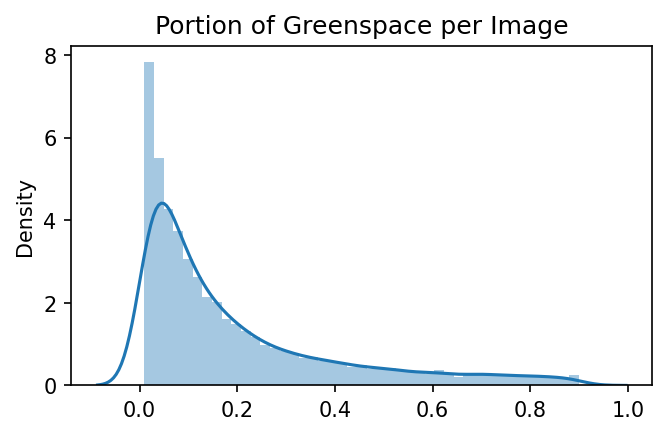

In [18]:
fig, ax = plt.subplots(figsize=(5, 3), dpi=150)
sns.distplot(greenspace_portion)
plt.title(f"Portion of Greenspace per Image")
plt.savefig(f"plots/greenspace_portion.png")
plt.show()